In [1]:
import numpy as np
import os, subprocess
from matplotlib import pyplot as plt
from scipy.optimize import least_squares
from struct import *

import can
import time
import math
from IPython.display import display, clear_output
from joint_can import *
%matplotlib inline


# Ustawienie temperatury

In [2]:
def initialize_joint(bus):
    send_msg(0x0A0, None, bus)
    time.sleep(1)
    
    send_msg(0x0b0, [0,0,0,0,0,0], bus)
    time.sleep(0.1)
    send_msg(0x040, None, bus)
    time.sleep(0.1)
    send_msg(0x0a0, None, bus)
    time.sleep(1)
    
    if (send_msg(0x0F0, [2, 2], bus).data[0] == 1):
        send_msg(0x010, [2], bus)
        time.sleep(1)
        print(send_msg(0x010, [3], bus).data[0])
        time.sleep(5)
        return True
    else:
        return False
     

In [3]:
bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
initialize_joint(bus)

2


True

parametry temperatury

In [4]:
min_temp = 30
max_temp = 31
speed = 1. #predkosc na ktorej joint jest rozgrzewany

In [5]:
c_speed=0.
j_data=set_speed(c_speed,bus)

while(j_data.bearing_temp<min_temp or j_data.bearing_temp>max_temp):
    if j_data.bearing_temp<min_temp:
        c_speed=speed
    else:
        c_speed=0.
    j_data=set_speed(c_speed,bus)
    print(f'\r tq: {j_data.torque:.3f}\tm_temp: {j_data.motor_temp:.3f}\tb_temp: {j_data.bearing_temp:.3f}', end='')
    time.sleep(1)
send_msg(0x0A0, None, bus)

 tq: 23.566	m_temp: 34.000	b_temp: 30.000

# Kalibracja tarcia

In [6]:
serial="JANUSZ_3_RI80_21414842" #musi byc min jedna litera w numerze

In [7]:
path = "/home/ubuntu/joint_diagnostic/friction_data"

In [8]:
try: 
    os.mkdir(path+'/'+serial) 
except OSError as error: 
    pass

In [9]:
if len(serial):
    # stream = os.popen('/home/ubuntu/run_friction.sh '+str(serial))
    subprocess.Popen(['/home/ubuntu/run_friction.sh',str(serial)]).communicate()[0]
    
    # output = stream.read()
    # print(output)

launching friction calibration
[INFO] [launch]: All log files can be found below /home/ubuntu/.ros/log/2022-07-19-14-54-01-787710-ubuntu-10250
[INFO] [launch]: Default logging verbosity is set to INFO
[INFO] [hw_interface-1]: process started with pid [10252]
[INFO] [friction_calibration-2]: process started with pid [10254]
[hw_interface-1] Opening CAN socket...
[hw_interface-1] Configuring IO...
[hw_interface-1] Successfully configured IO.
[hw_interface-1] Clear shared memory location
[hw_interface-1] Allocating 880 bytes
[hw_interface-1] Create shared memory location
[hw_interface-1] Create shared memory variables
[friction_calibration-2] [INFO] [1658242442.203500619] [base_controller]: Initialization watchdog for module "base_controller"
[hw_interface-1] Done initializing shared memory
[hw_interface-1] 17333
[hw_interface-1] Initializing connection with CAN.
[hw_interface-1] Established connection with CAN
[hw_interface-1] Arm connection initialization successfull.
[hw_interface-1] S

In [10]:
if __name__ == "__main__":

    bus = can.interface.Bus(bustype='socketcan', channel='can0', bitrate=1000000, data_bitrate=5000000, fd=True)
    initialize_joint(bus)

2


In [11]:
send_msg(0x0A0, None, bus)
time.sleep(1)
send_msg(0x0F0, [2,2], bus)
send_msg(0x010, [2], bus)
time.sleep(0.1)
send_msg(0x010, [3], bus)
time.sleep(6)


data=set_speed(0,bus)

sgn=-(int(data.position>0) - int(data.position<0))

data=set_speed(sgn*0.1,bus)

while(abs(data.position)>0.01):
    if (abs(data.position)>0.2):
        data=set_speed(sgn*0.2,bus)
    else:
        data=set_speed(sgn*0.05,bus)
    time.sleep(0.1)

send_msg(0x010, [2], bus)

can.Message(timestamp=1658243768.8668847, arbitration_id=0x210, is_extended_id=False, channel='can0', dlc=1, data=[0x3], is_fd=True, bitrate_switch=True, error_state_indicator=False)

In [12]:
def model(k, v, t, tq):
    return (1 + k[4]*(t - k[5])) * (k[0] * np.sign(v) + k[1] * v + k[2] * v ** 2 * np.sign(v) + k[3] * v ** 3) - tq


def fun(k, v, t):
    return (1 + k[4]*(t - k[5])) * (k[0] * np.sign(v) + k[1] * v + k[2] * v ** 2 * np.sign(v) + k[3] * v ** 3)

In [13]:
flist=os.listdir(path+'/'+ serial)
for file in flist:
    if file[0] == '.':
        flist.remove(file)

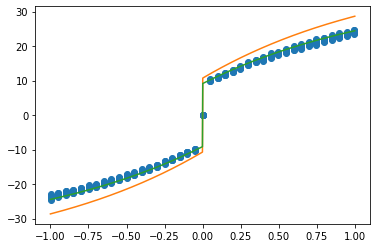

can.Message(timestamp=1658243769.514864, arbitration_id=0x240, is_extended_id=False, channel='can0', dlc=1, data=[0x1], is_fd=True, bitrate_switch=True, error_state_indicator=False)

In [14]:
# for dir in dlist:
#     data_points = []
#     files_processed = 0
#     flist = os.listdir(path + '/' + dir)
flist=os.listdir(path+'/'+ serial)
data_points=[]
files_processed = 0
for fname in flist:
    if '.txt' in fname and 'coeffs' not in fname:
        with open(path + '/' + serial + '/' + fname) as file:
            data_points += (list(file))
            files_processed += 1
data_points = [point.split() for point in data_points]
data_points = np.array(data_points, dtype=float)

tq_train = data_points[:, 1]
v_train = data_points[:, 0]
t_train = data_points[:, 2]
k0 = [5., 15., 0., -5., -0.1, 20.]
res_lsq = least_squares(model, k0, args=(v_train, t_train, tq_train), jac='3-point', loss='cauchy',
                        max_nfev=10000000, gtol=1e-10, ftol=1e-12)

plt.plot(v_train, tq_train, 'o')
v_test = np.linspace(-1, 1, 1000)

y_lsq = fun(res_lsq.x, v_test, 20)
plt.plot(v_test, y_lsq)

y_lsq = fun(res_lsq.x, v_test, 30)
plt.plot(v_test, y_lsq)

plt.show()

friction_data=[96,12]

with open(path + '/' + serial + '/' + 'friction_coeffs' + '.txt', 'w') as file:
    for c in res_lsq.x:
        friction_data.append(float(c))
        file.write(str(c) + '\n')
friction_data_b=pack('>BBffffff',*friction_data)
send_msg(0x030, friction_data_b, bus)
send_msg(0x040, None, bus)
